In [ ]:
from torchview import draw_graph
import torch
import torch.nn as nn
import antialiased_cnns

In [2]:
class DeltaDINO(nn.Module):
    def __init__(self,
                 channels=[3, 64, 128, 256, 1024],
                 dilations=[1, 1, 1, 2],
                 kernel_size=5,
                 down_stride=2,
                 padding_mode="reflect",
                 downsample_layers=[True, True, True, False],
                 vit_stride=7
                 ):
        super(DeltaDINO, self).__init__()
        
        self.downsample_layers = downsample_layers
        self.vit_stride = vit_stride
        self.down_stride = down_stride
        
        # create layers
        self.layers_list = []
        for i in range(len(channels)-1):    
            is_last_layer = i == len(channels) - 2    
            dilation = dilations[i]
            padding = (kernel_size + ((kernel_size-1) * (dilation-1))) // 2
            conv_layer = nn.Conv2d(channels[i], channels[i+1], kernel_size=kernel_size, stride=1, dilation=dilation,
                                   padding=padding, padding_mode=padding_mode)
            # zero init
            if is_last_layer:
                conv_layer.weight.data = torch.zeros_like(conv_layer.weight.data).to(conv_layer.weight.data.device)
                conv_layer.bias.data = torch.zeros_like(conv_layer.bias.data).to(conv_layer.bias.data.device)

            self.layers_list.append(conv_layer)
            self.layers_list.append(nn.BatchNorm2d(channels[i+1]))
            if is_last_layer:
                # initialize gamma of batch norm to inital_gamma
                self.layers_list[-1].weight.data.fill_(0.05)
            if not is_last_layer:
                self.layers_list.append(nn.ReLU())
            if self.downsample_layers[i]:
                self.layers_list.append(antialiased_cnns.BlurPool(channels[i+1], stride=down_stride))

        self.layers = torch.nn.ModuleList(self.layers_list)

    def get_total_stride(self):
        # assumes that model does not contain upsampling layers
        n_down = sum(self.downsample_layers)
        return self.down_stride ** n_down

    def forward(self, x
                # , vit_features
                ):
        for layer in self.layers:
            x = layer(x)
        
        # cnn_stride = self.get_total_stride()
        # x = align_cnn_vit_features(vit_features_bchw=vit_features, cnn_features_bchw=x,
        #                             cnn_stride=cnn_stride, vit_stride=self.vit_stride)
         
        return x

In [6]:
draw_graph

<function torchview.torchview.draw_graph(model: 'nn.Module', input_data: 'INPUT_DATA_TYPE | None' = None, input_size: 'INPUT_SIZE_TYPE | None' = None, graph_name: 'str' = 'model', depth: 'int | float' = 3, device: 'torch.device | str | None' = None, dtypes: 'list[torch.dtype] | None' = None, mode: 'str | None' = None, strict: 'bool' = True, expand_nested: 'bool' = False, graph_dir: 'str | None' = None, hide_module_functions: 'bool' = True, hide_inner_tensors: 'bool' = True, roll: 'bool' = False, show_shapes: 'bool' = True, save_graph: 'bool' = False, filename: 'str | None' = None, directory: 'str' = '.', **kwargs: 'Any') -> 'ComputationGraph'>

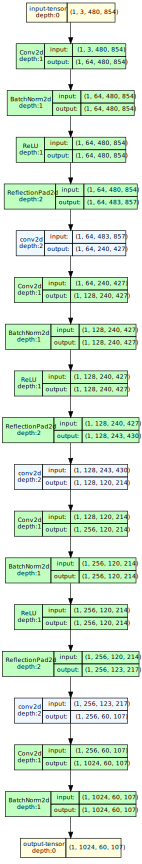

In [24]:
model_graph = draw_graph(DeltaDINO(), input_size=(1, 3, 480, 854), expand_nested=False,graph_name="Delta-DINO",roll=True,graph_dir="../Report/figs",save_graph=True)
model_graph.visual_graph

In [25]:
em = torch.load("../dataset/tapvid-davis/1/dino_embeddings/dino_embed_video.pt")
em.shape

torch.Size([75, 1024, 67, 121])

In [15]:
from models.utils import align_cnn_vit_features

In [ ]:
alligned = align_cnn_vit_features(em.cpu(),torch.zeros((90,1024,60,107)))
alligned.shape

torch.Size([90, 1024, 67, 121])